In [1]:
# Set autoreload libraries every time before executing
%load_ext autoreload
%autoreload 2

In [2]:
from utils.helper import get_fanatics, get_indegree, get_data
from utils.visualize import visualize_coevolution, visualize_clustering_coeff, visualize_indegree, line_plot_with_confidence_interval, visualize_graph, animate_network

# Load simulation results

In [3]:
# Change the date time to the date time of the pickle file you want to load
DATE = '241003'
TIME = '0819'
data_fanatics, data_no_fanatics = get_data(DATE, TIME)

### Last network

In [4]:
# Add the last network and belief to the data_fanatics DataFrame
data_fanatics['last_network'] = data_fanatics['network_array'].apply(lambda x: x[-1])
data_fanatics['last_belief'] = data_fanatics['belief_array'].apply(lambda x: x[-1])

# Add the last network and belief to the data_non_fanatics DataFrame
data_no_fanatics['last_network'] = data_no_fanatics['network_array'].apply(lambda x: x[-1])
data_no_fanatics['last_belief'] = data_no_fanatics['belief_array'].apply(lambda x: x[-1])

### In-degree

In [5]:
data_fanatics['last_indegree'] = data_fanatics['last_network'].apply(lambda x: get_indegree(x))
data_no_fanatics['last_indegree'] = data_no_fanatics['last_network'].apply(lambda x: get_indegree(x))

### Split dataset

3 datasets
- `fanatics_scheme == 'max'`: all fanatics have a belief of 1.
- `fanatics_scheme == 'min-max'`: half of the fanatics have a belief of 0, the other half have a belief of 1.
- `fanatics_scheme == 'mean'`: all fanatics have a belief of 0.5.

In [6]:
fanatics_max_low = get_fanatics(data_fanatics, data_no_fanatics, 'max', 0.5)
fanatics_max_high = get_fanatics(data_fanatics, data_no_fanatics, 'max', 1)
fanatics_min_max_low = get_fanatics(data_fanatics, data_no_fanatics, 'min-max', 0.5)
fanatics_min_max_high = get_fanatics(data_fanatics, data_no_fanatics, 'min-max', 1)
fanatics_mean_low = get_fanatics(data_fanatics, data_no_fanatics, 'mean', 0.5)
fanatics_mean_high = get_fanatics(data_fanatics, data_no_fanatics, 'mean', 1)

print(fanatics_max_low.shape, fanatics_min_max_high.shape, fanatics_mean_high.shape)

(25, 58) (25, 58) (25, 58)


# Analyze results


## Visuals

### Network and Belief Coevolution

In [7]:
beta = fanatics_max_low['beta'].unique()
for b in beta:
    visualize_coevolution(fanatics_max_low, b, DATE, TIME, export=True)

beta = fanatics_max_high['beta'].unique()
for b in beta:
    visualize_coevolution(fanatics_max_high, b, DATE, TIME, export=True)

beta = fanatics_min_max_low['beta'].unique()
for b in beta:
    visualize_coevolution(fanatics_min_max_low, b, DATE, TIME, export=True)

beta = fanatics_min_max_high['beta'].unique()
for b in beta:
    visualize_coevolution(fanatics_min_max_high, b, DATE, TIME, export=True)

beta = fanatics_mean_low['beta'].unique()
for b in beta:
    visualize_coevolution(fanatics_mean_low, b, DATE, TIME, export=True)

beta = fanatics_mean_high['beta'].unique()
for b in beta:
    visualize_coevolution(fanatics_mean_high, b, DATE, TIME, export=True)

### Clustering coefficient

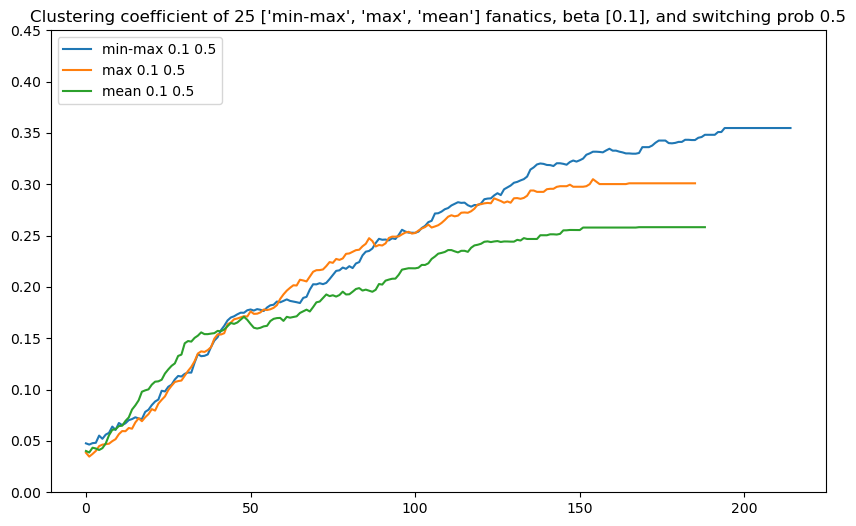

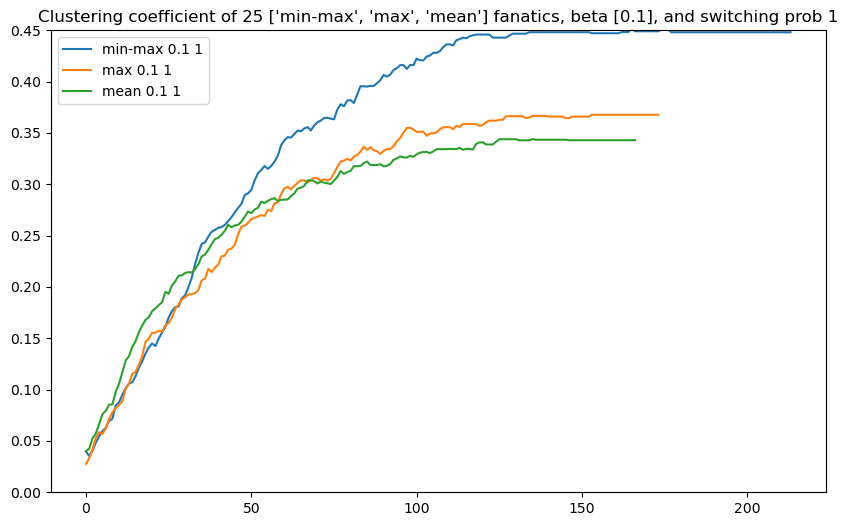

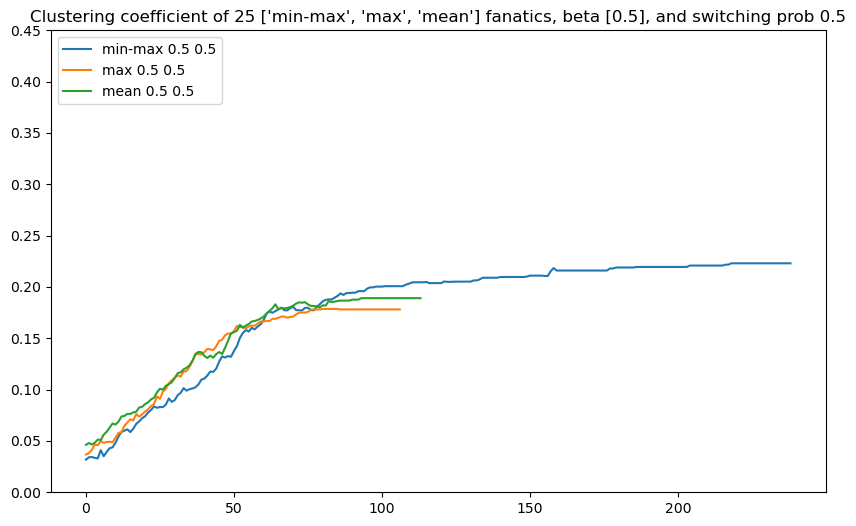

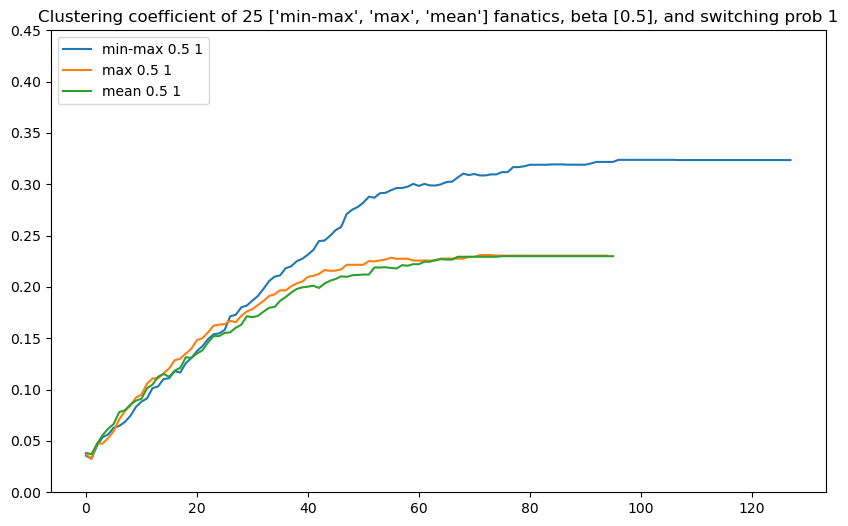

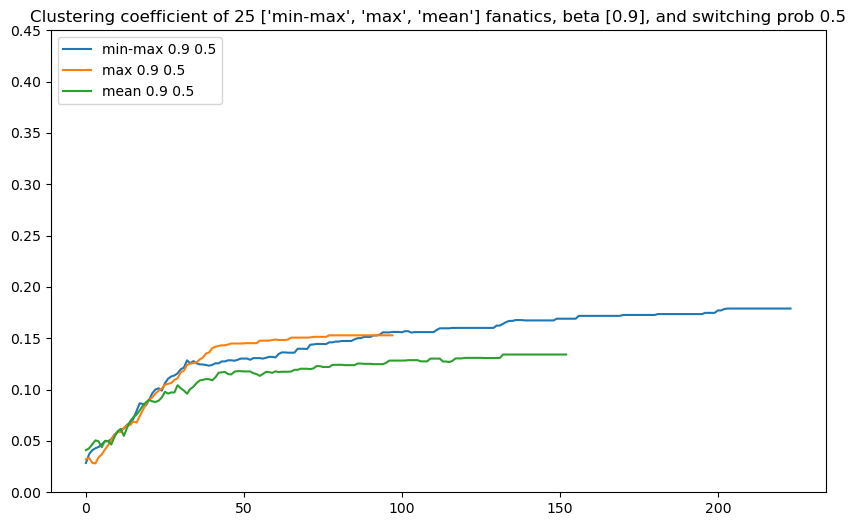

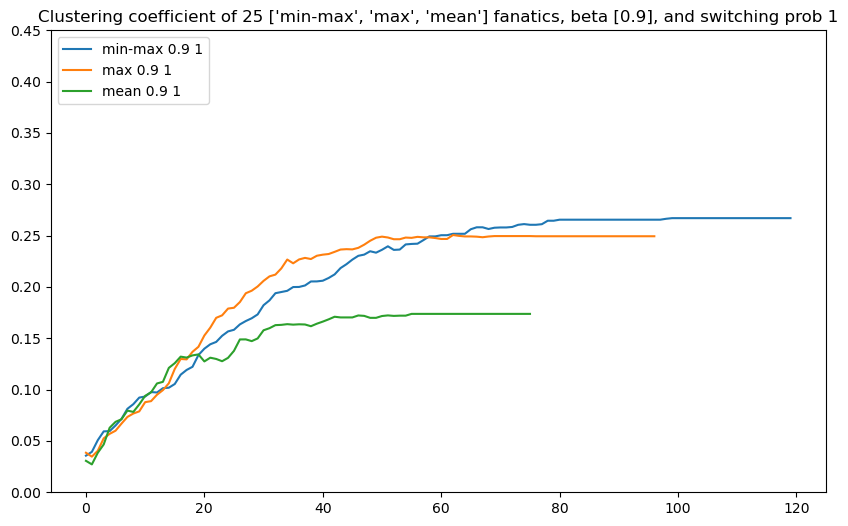

In [8]:
_ = visualize_clustering_coeff(data_fanatics, data_no_fanatics, ["min-max", "max", "mean"], [0.1], num_fanatics=25, switching_prob=0.5, date=DATE, time=TIME, export=True)
_ = visualize_clustering_coeff(data_fanatics, data_no_fanatics, ["min-max", "max", "mean"], [0.1], num_fanatics=25, switching_prob=1, date=DATE, time=TIME, export=True)
_ = visualize_clustering_coeff(data_fanatics, data_no_fanatics, ["min-max", "max", "mean"], [0.5], num_fanatics=25, switching_prob=0.5, date=DATE, time=TIME, export=True)
_ = visualize_clustering_coeff(data_fanatics, data_no_fanatics, ["min-max", "max", "mean"], [0.5], num_fanatics=25, switching_prob=1, date=DATE, time=TIME, export=True)
_ = visualize_clustering_coeff(data_fanatics, data_no_fanatics, ["min-max", "max", "mean"], [0.9], num_fanatics=25, switching_prob=0.5, date=DATE, time=TIME, export=True)
_ = visualize_clustering_coeff(data_fanatics, data_no_fanatics, ["min-max", "max", "mean"], [0.9], num_fanatics=25, switching_prob=1, date=DATE, time=TIME, export=True)

### In-degree

/Users/quannz/Documents/Projects/social-network-v3/utils/visualize.py:181: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  g_indegree = sns.displot(data=temp, x='last_indegree', hue='beta', col='num_fanatics', col_wrap=4, palette=palette, multiple='stack', legend=False, stat='probability')
/Users/quannz/miniconda3/envs/research001/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


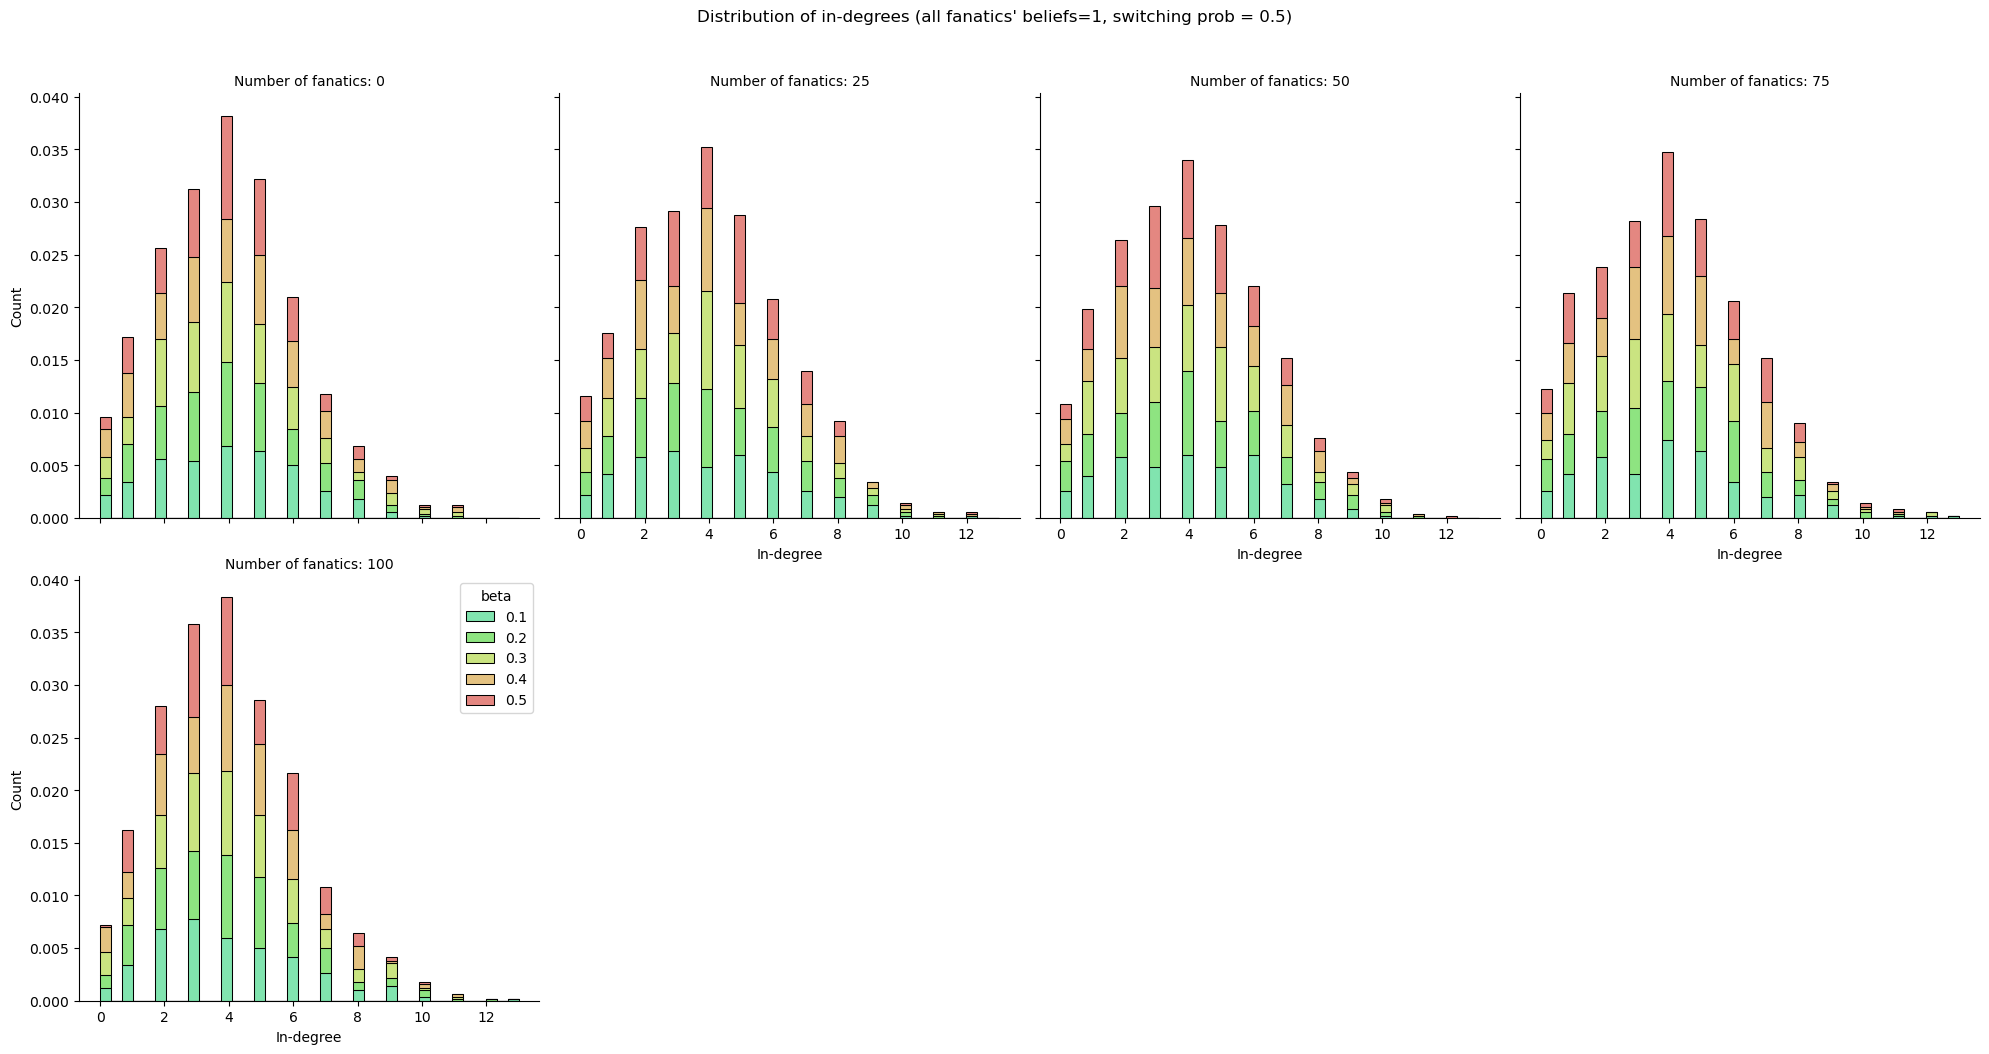

/Users/quannz/Documents/Projects/social-network-v3/utils/visualize.py:181: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  g_indegree = sns.displot(data=temp, x='last_indegree', hue='beta', col='num_fanatics', col_wrap=4, palette=palette, multiple='stack', legend=False, stat='probability')
/Users/quannz/miniconda3/envs/research001/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


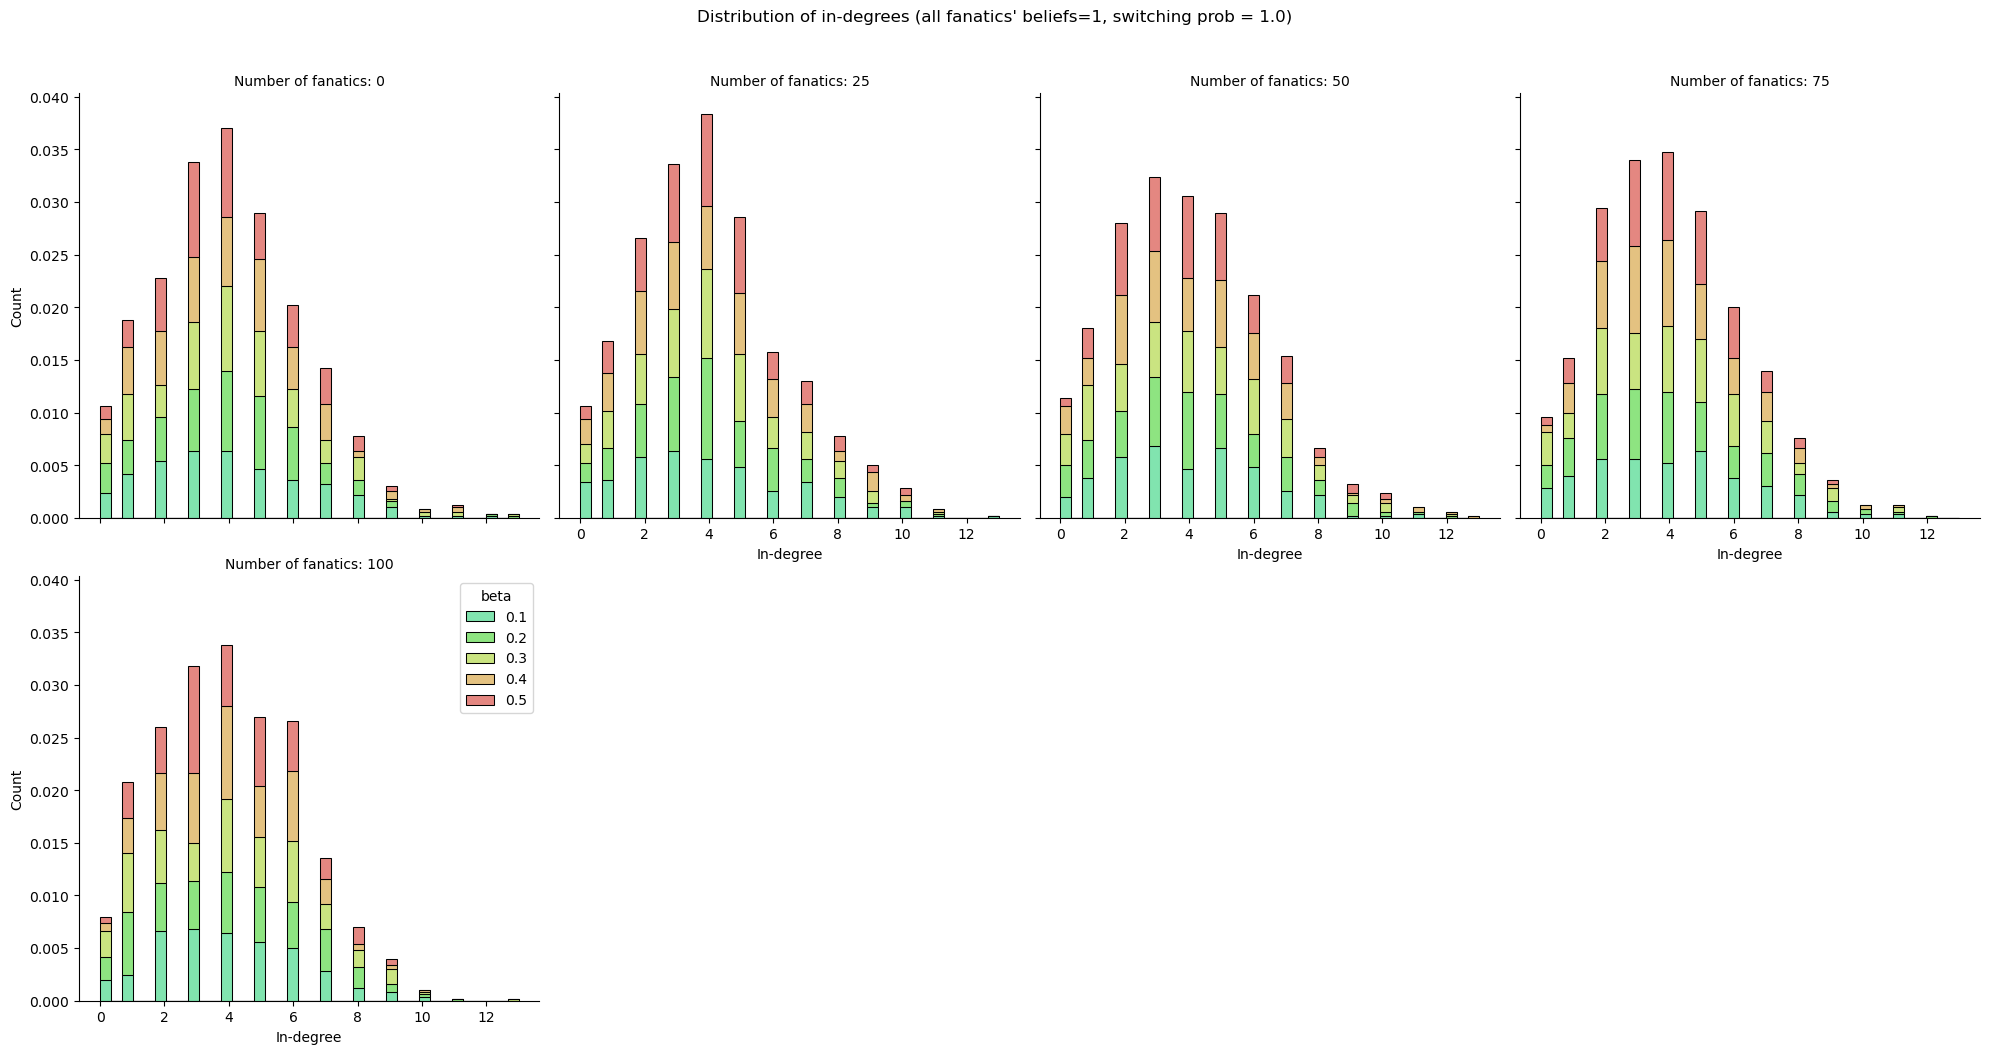

/Users/quannz/Documents/Projects/social-network-v3/utils/visualize.py:181: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  g_indegree = sns.displot(data=temp, x='last_indegree', hue='beta', col='num_fanatics', col_wrap=4, palette=palette, multiple='stack', legend=False, stat='probability')
/Users/quannz/miniconda3/envs/research001/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


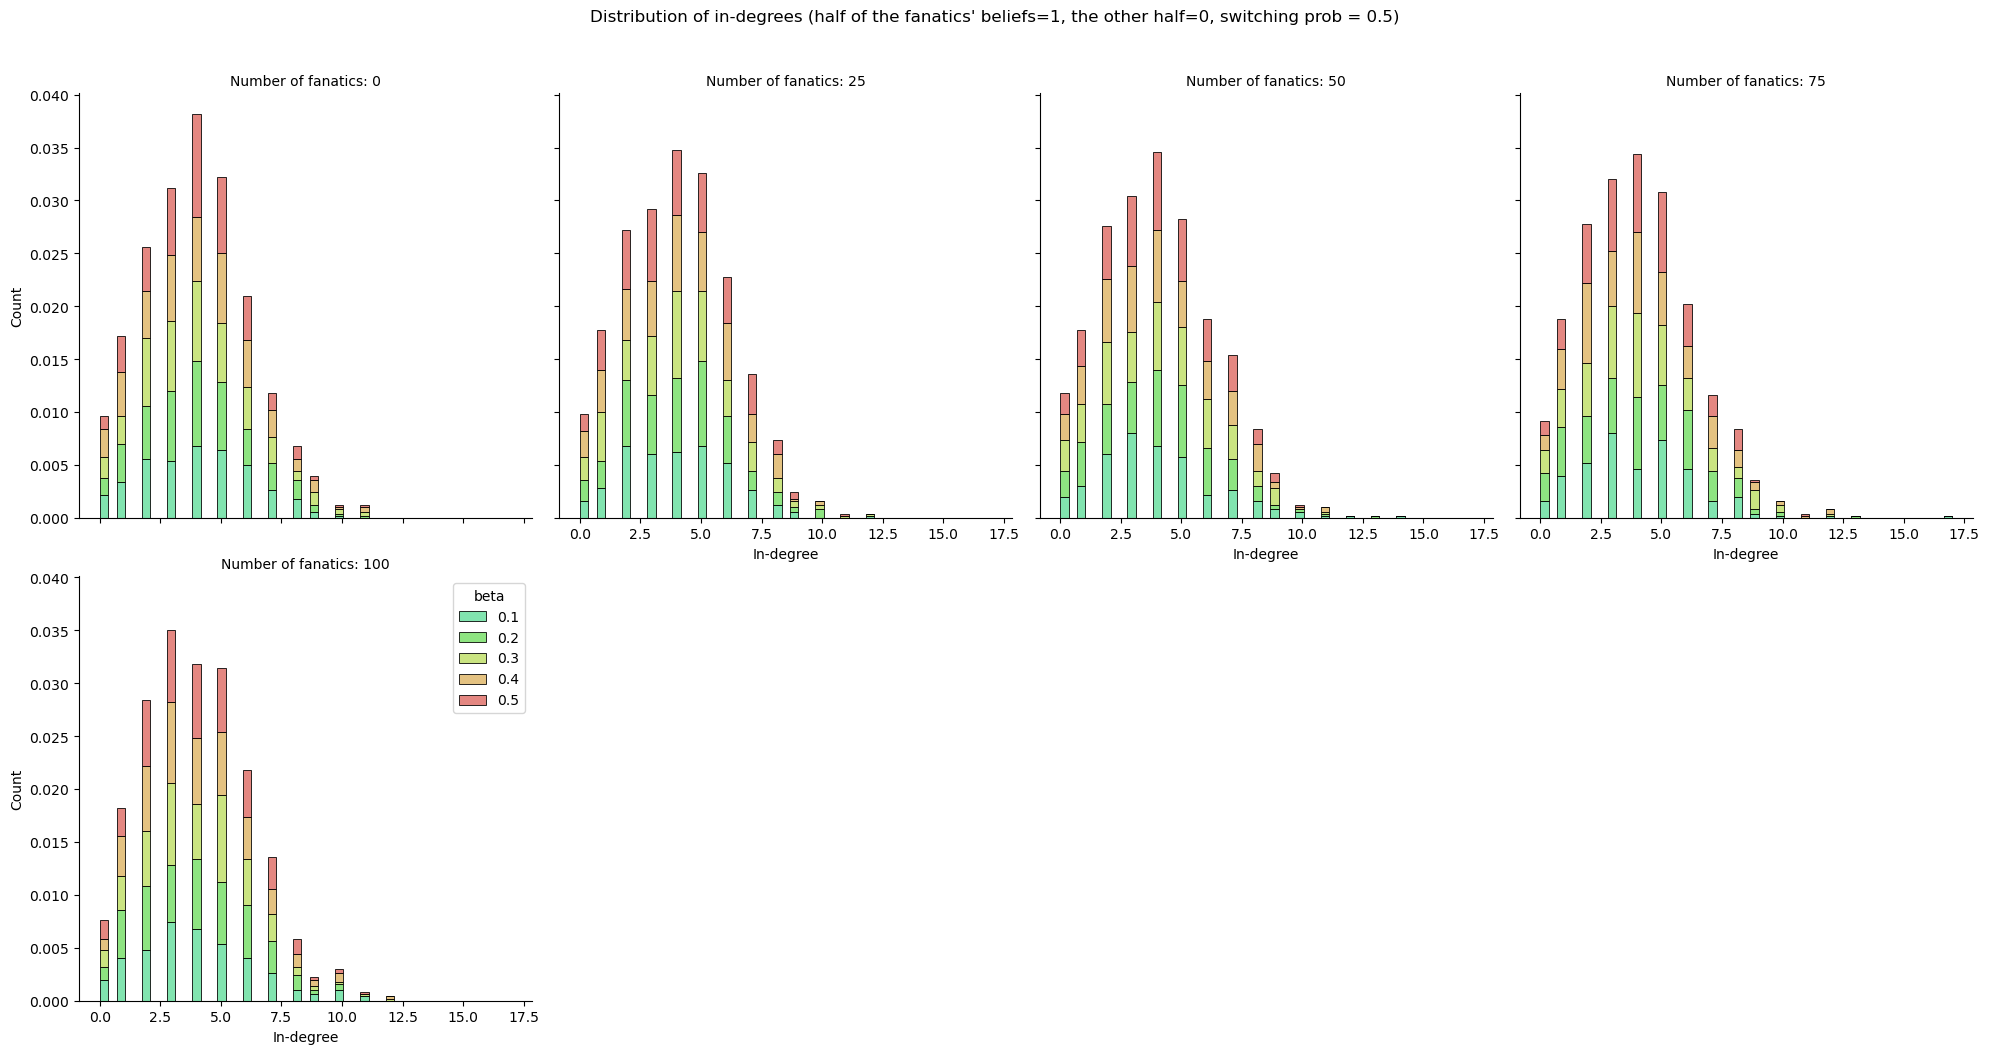

/Users/quannz/Documents/Projects/social-network-v3/utils/visualize.py:181: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  g_indegree = sns.displot(data=temp, x='last_indegree', hue='beta', col='num_fanatics', col_wrap=4, palette=palette, multiple='stack', legend=False, stat='probability')
/Users/quannz/miniconda3/envs/research001/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


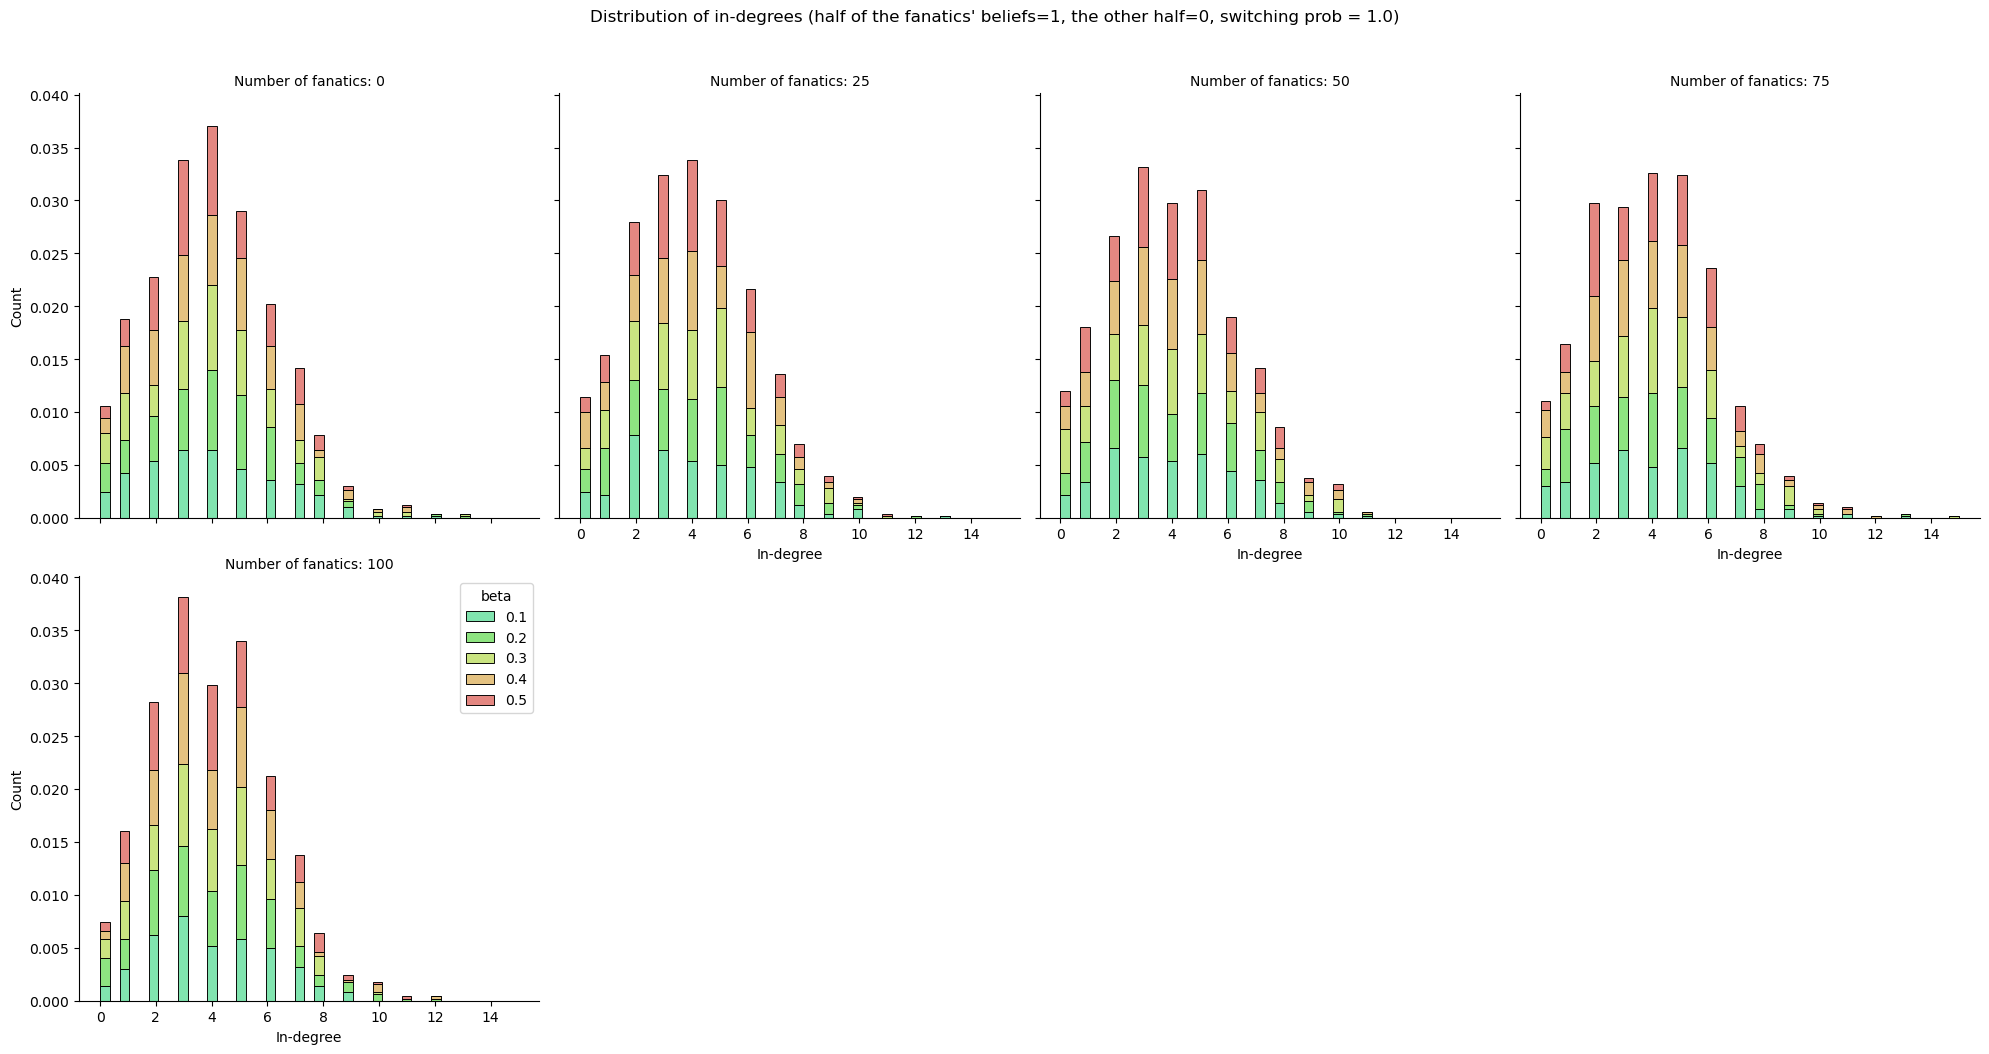

/Users/quannz/Documents/Projects/social-network-v3/utils/visualize.py:181: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  g_indegree = sns.displot(data=temp, x='last_indegree', hue='beta', col='num_fanatics', col_wrap=4, palette=palette, multiple='stack', legend=False, stat='probability')
/Users/quannz/miniconda3/envs/research001/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


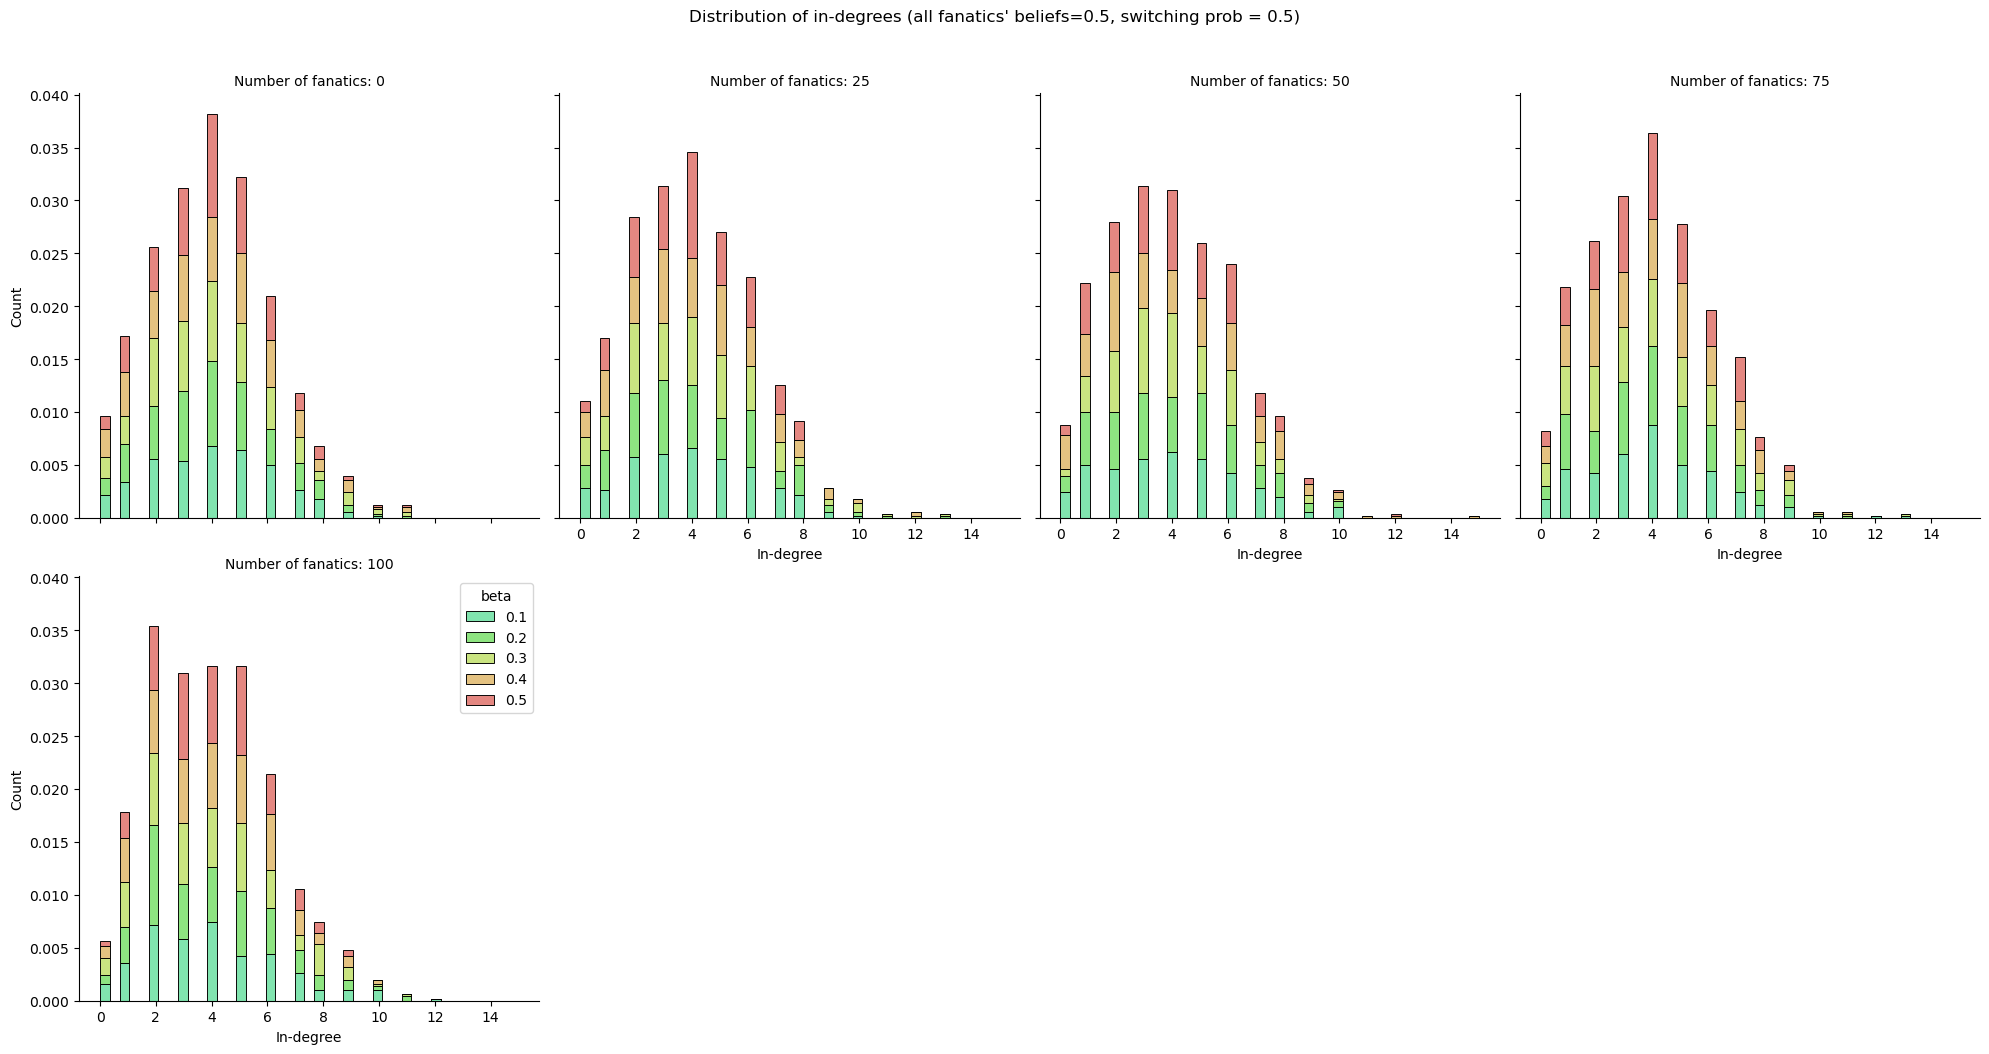

/Users/quannz/Documents/Projects/social-network-v3/utils/visualize.py:181: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  g_indegree = sns.displot(data=temp, x='last_indegree', hue='beta', col='num_fanatics', col_wrap=4, palette=palette, multiple='stack', legend=False, stat='probability')
/Users/quannz/miniconda3/envs/research001/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


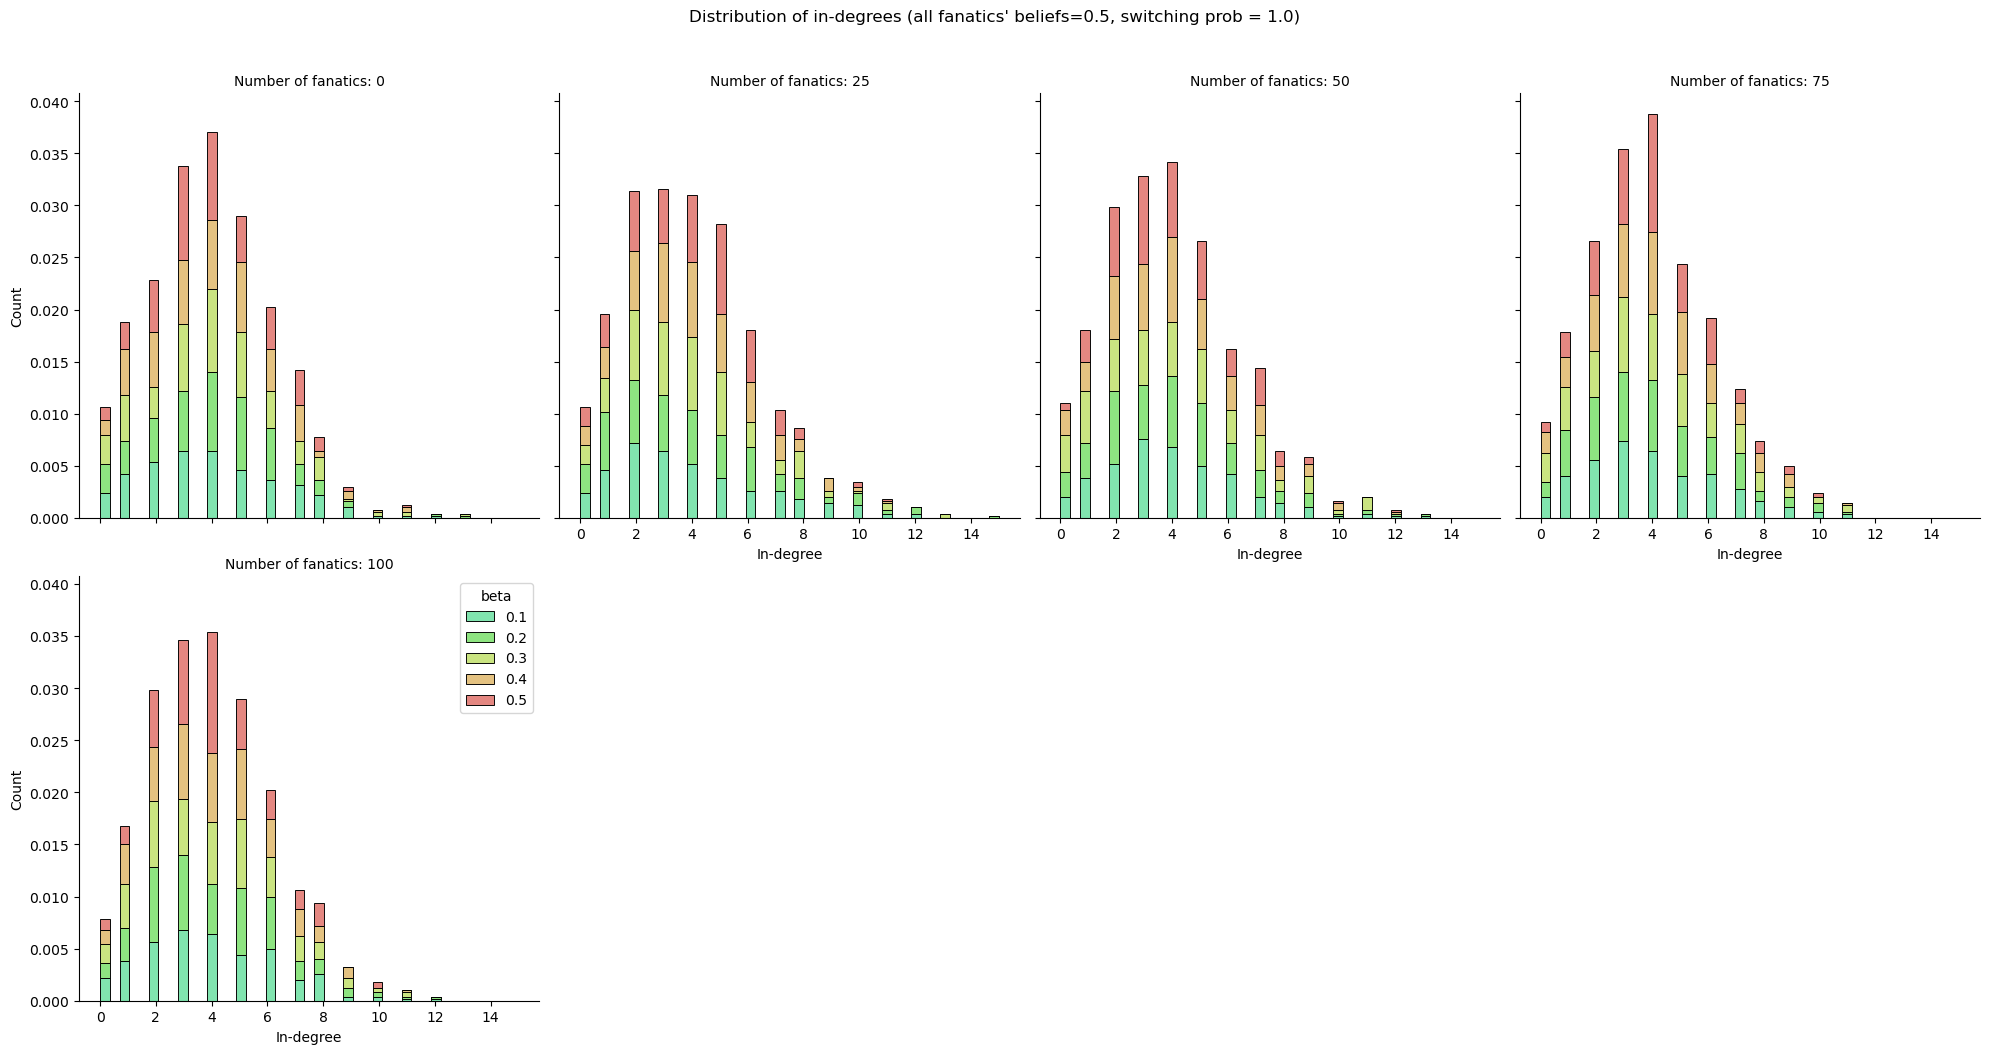

In [9]:
visualize_indegree(fanatics_max_low, DATE, TIME, export=True)
visualize_indegree(fanatics_max_high, DATE, TIME, export=True)
visualize_indegree(fanatics_min_max_low, DATE, TIME, export=True)
visualize_indegree(fanatics_min_max_high, DATE, TIME, export=True)
visualize_indegree(fanatics_mean_low, DATE, TIME, export=True)
visualize_indegree(fanatics_mean_high, DATE, TIME, export=True)

### Metrics

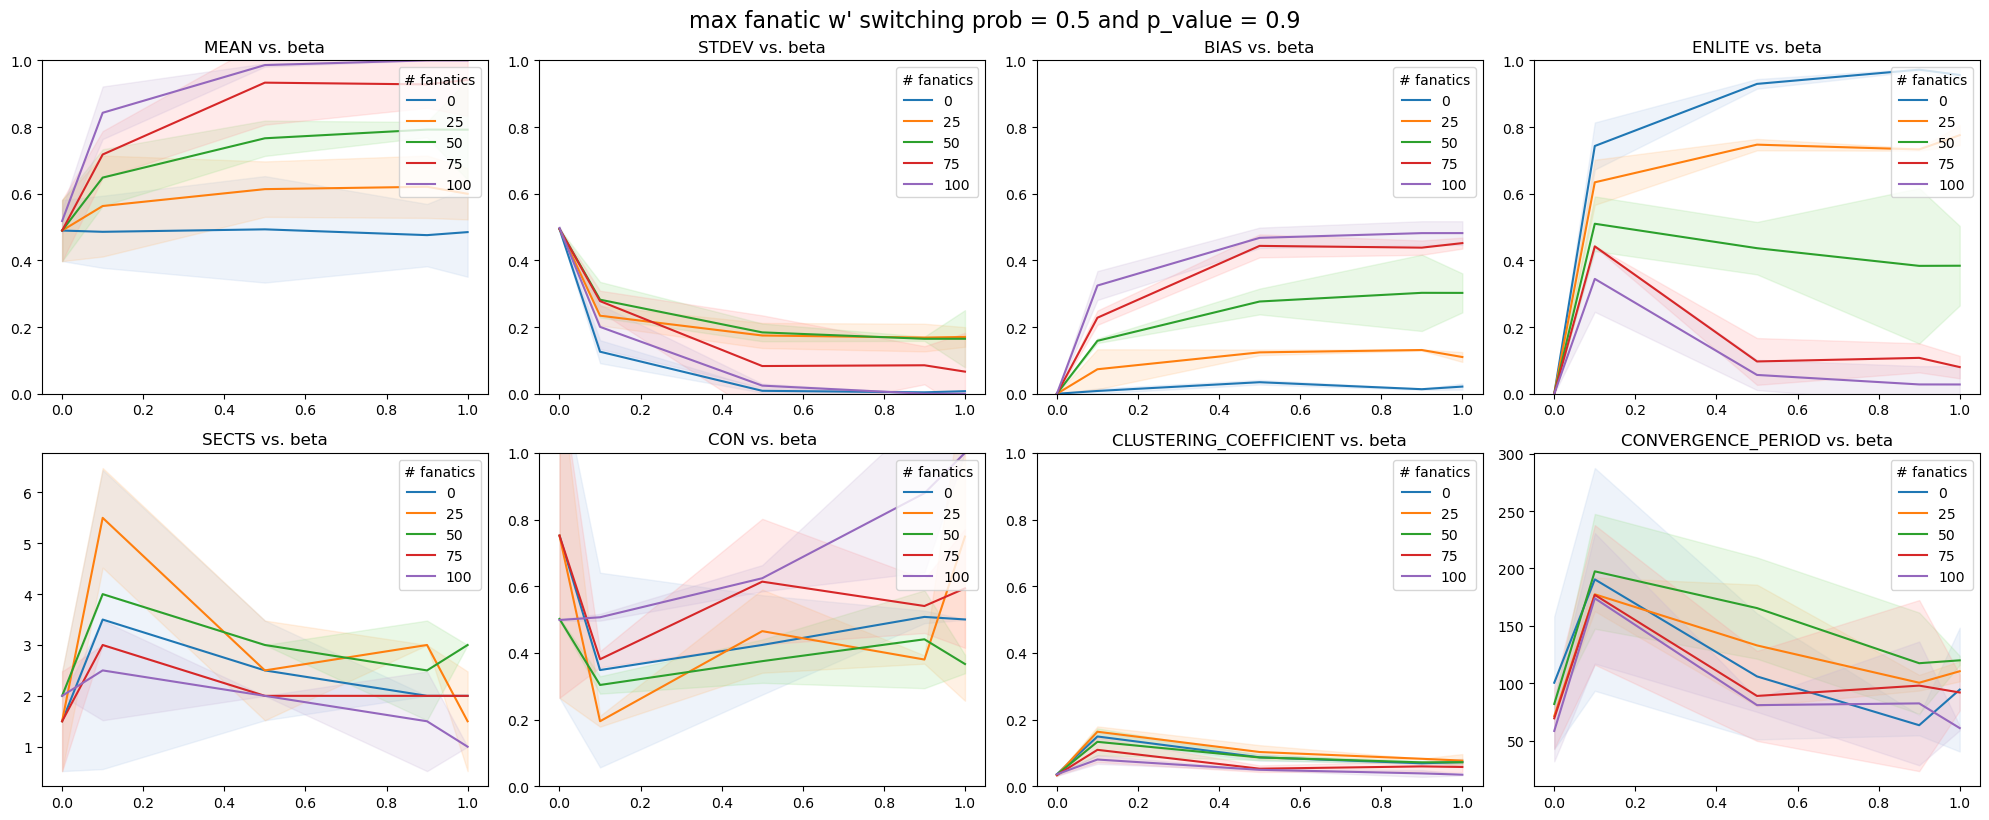

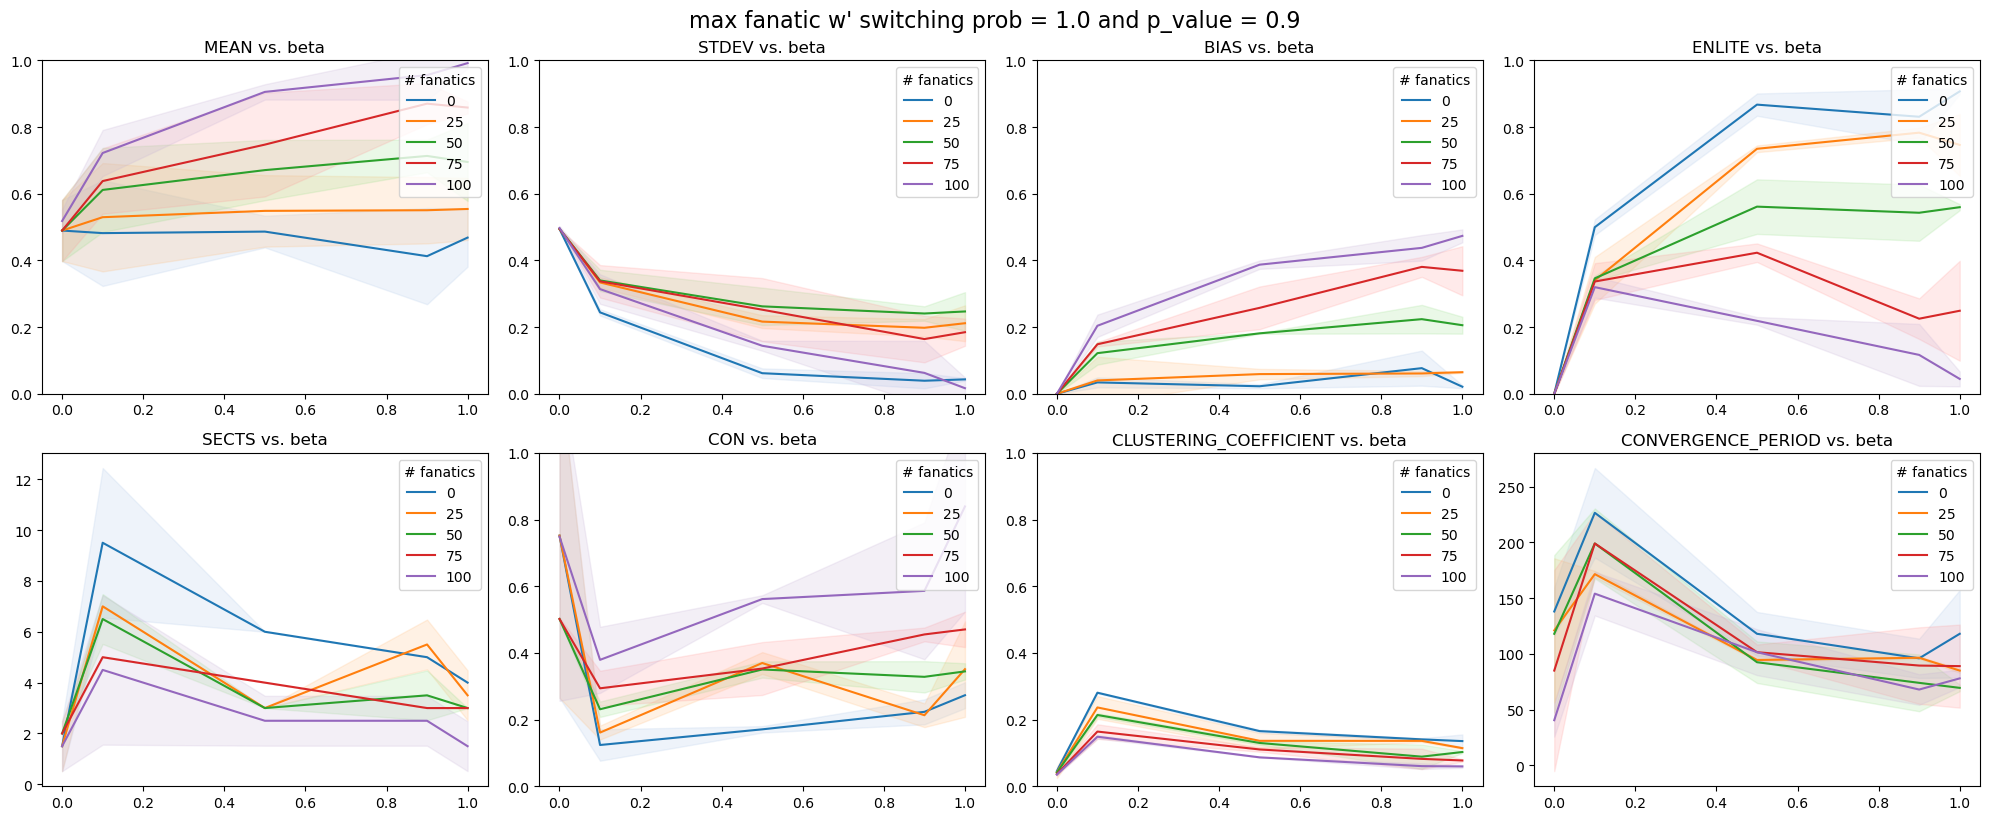

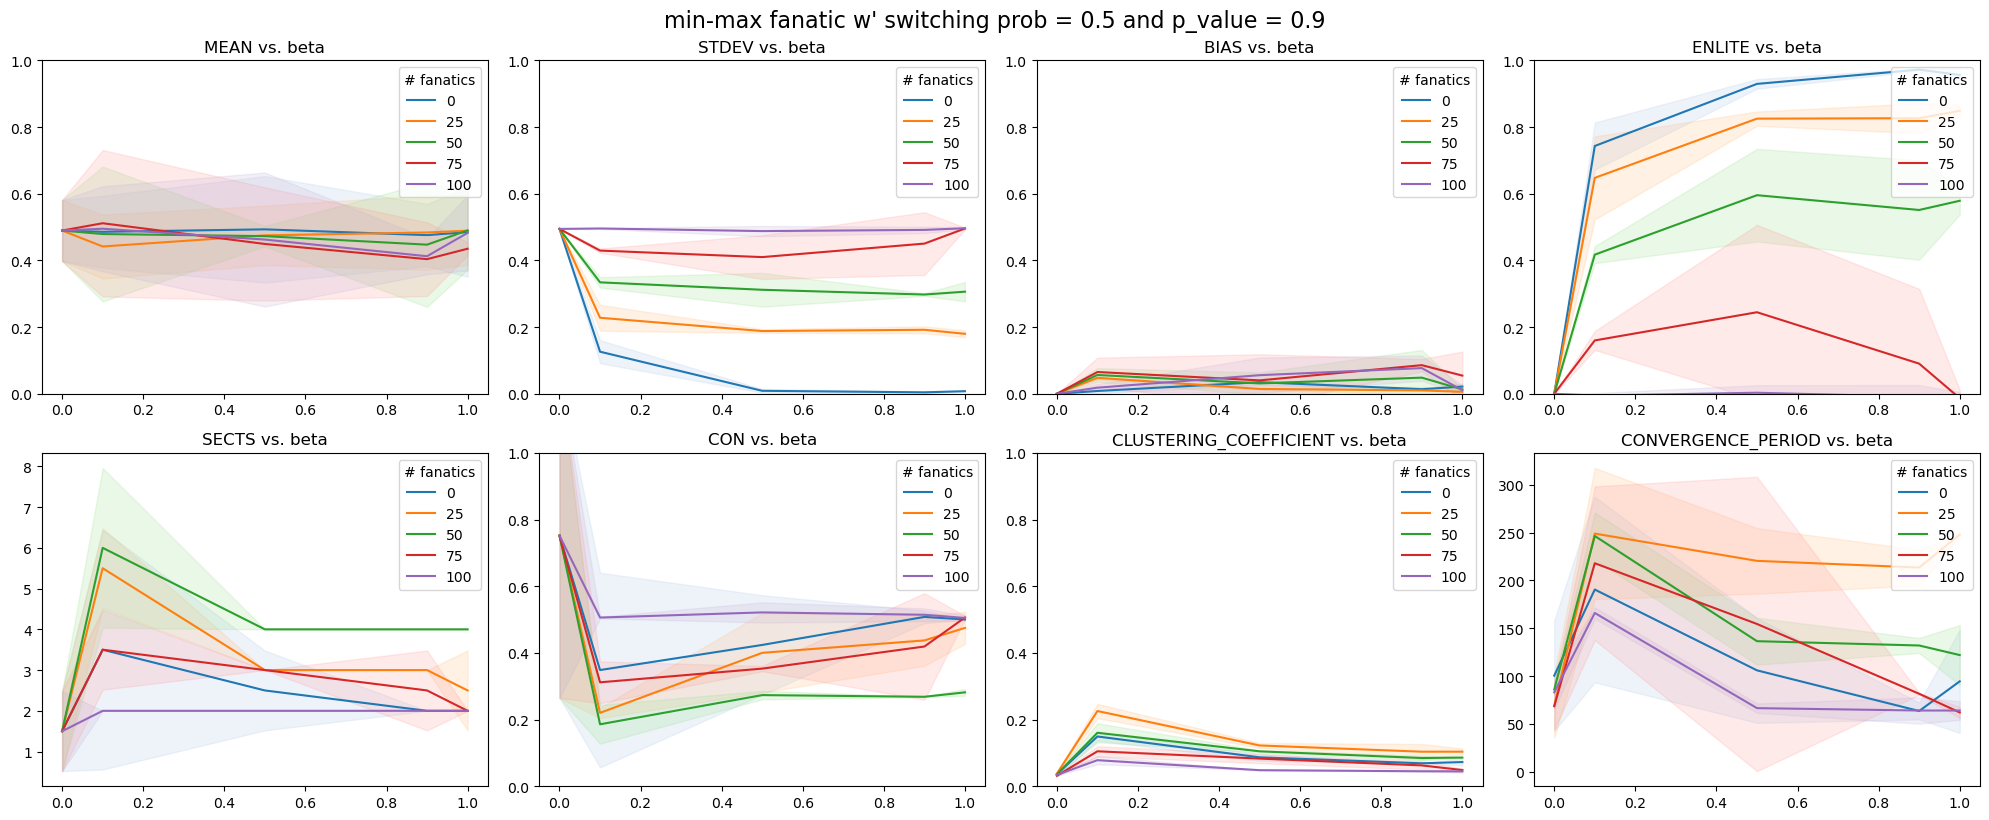

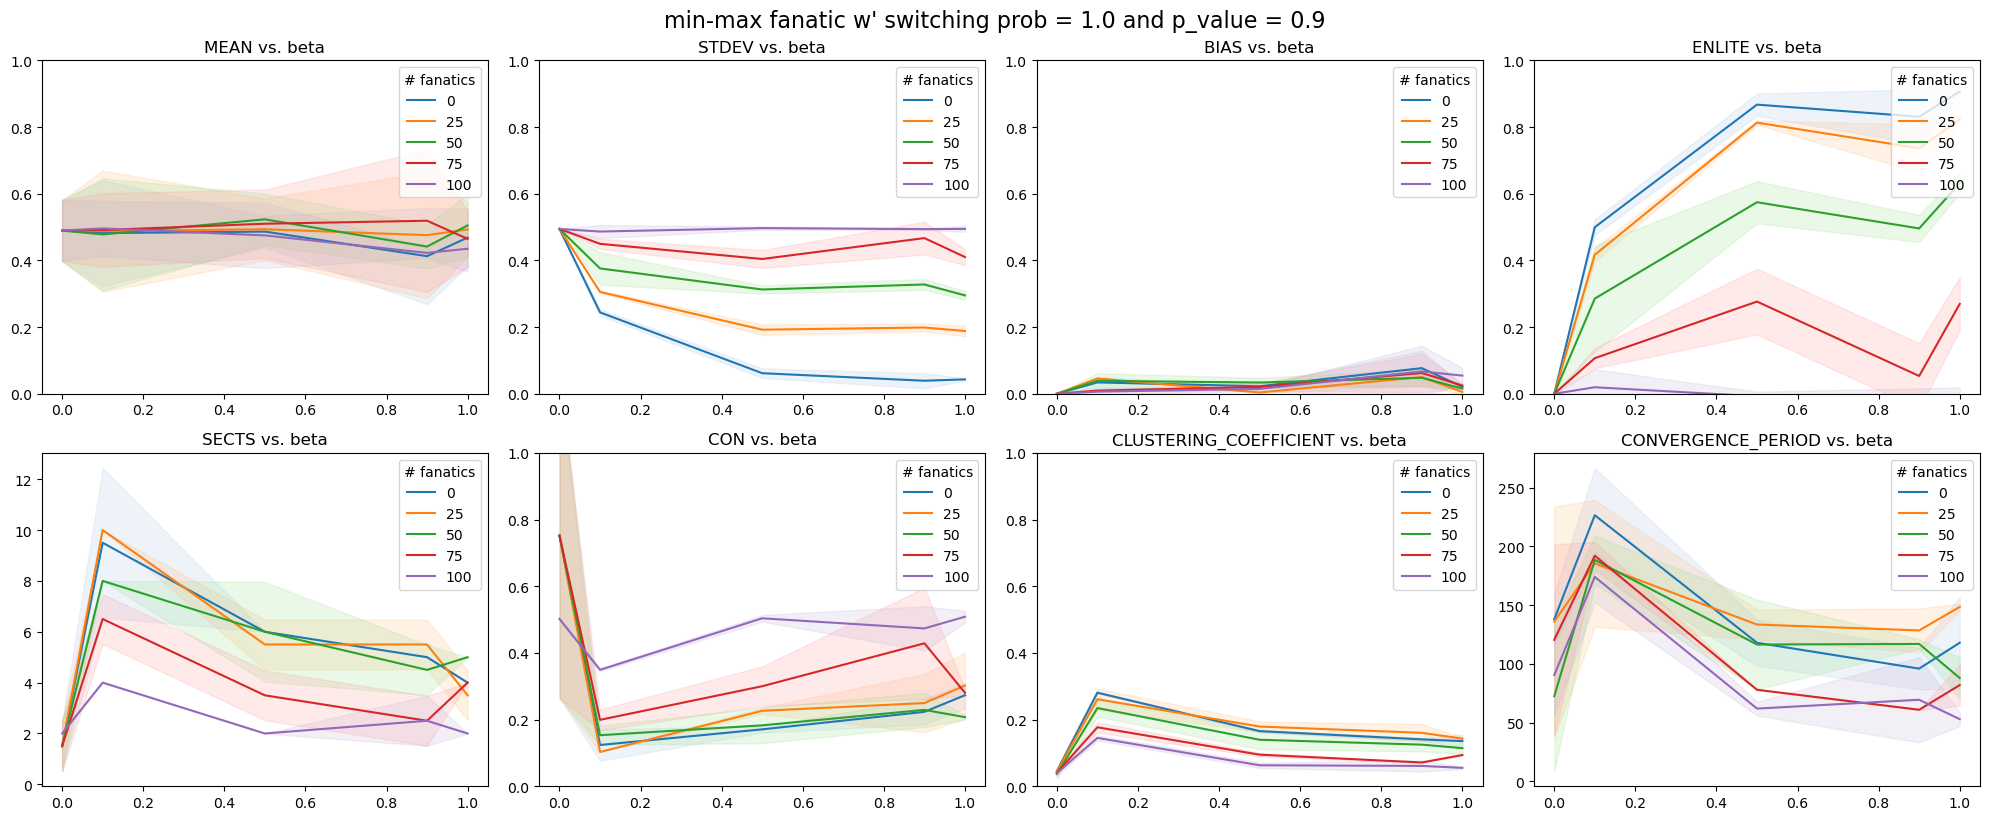

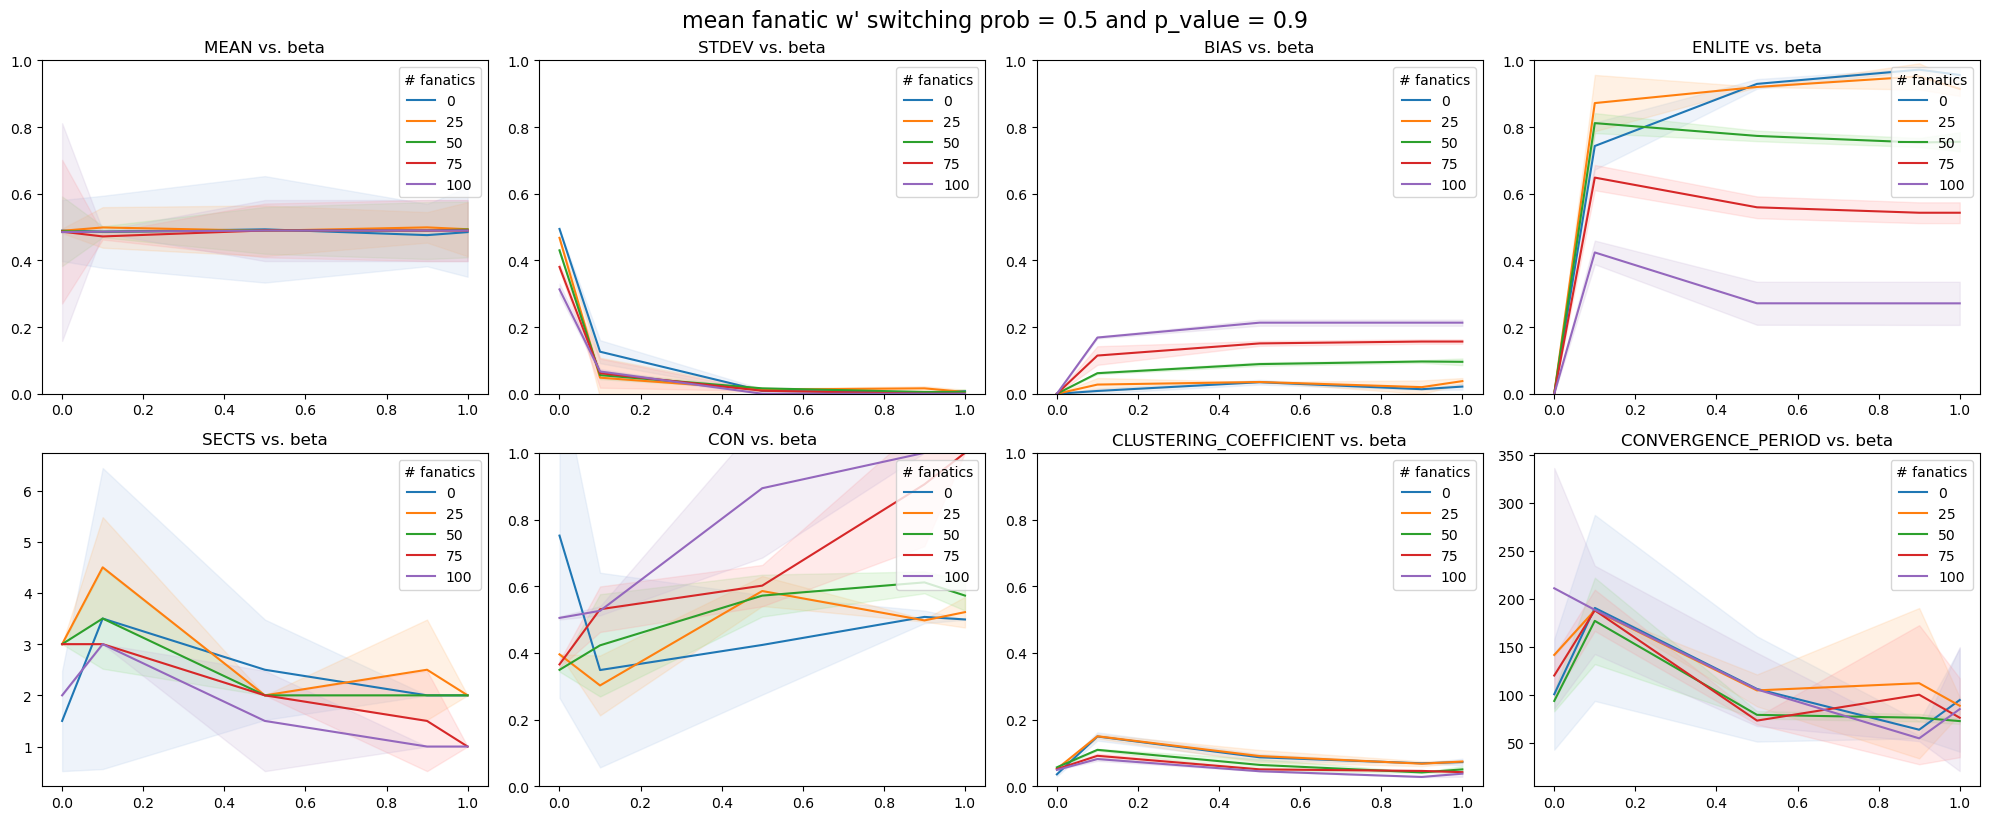

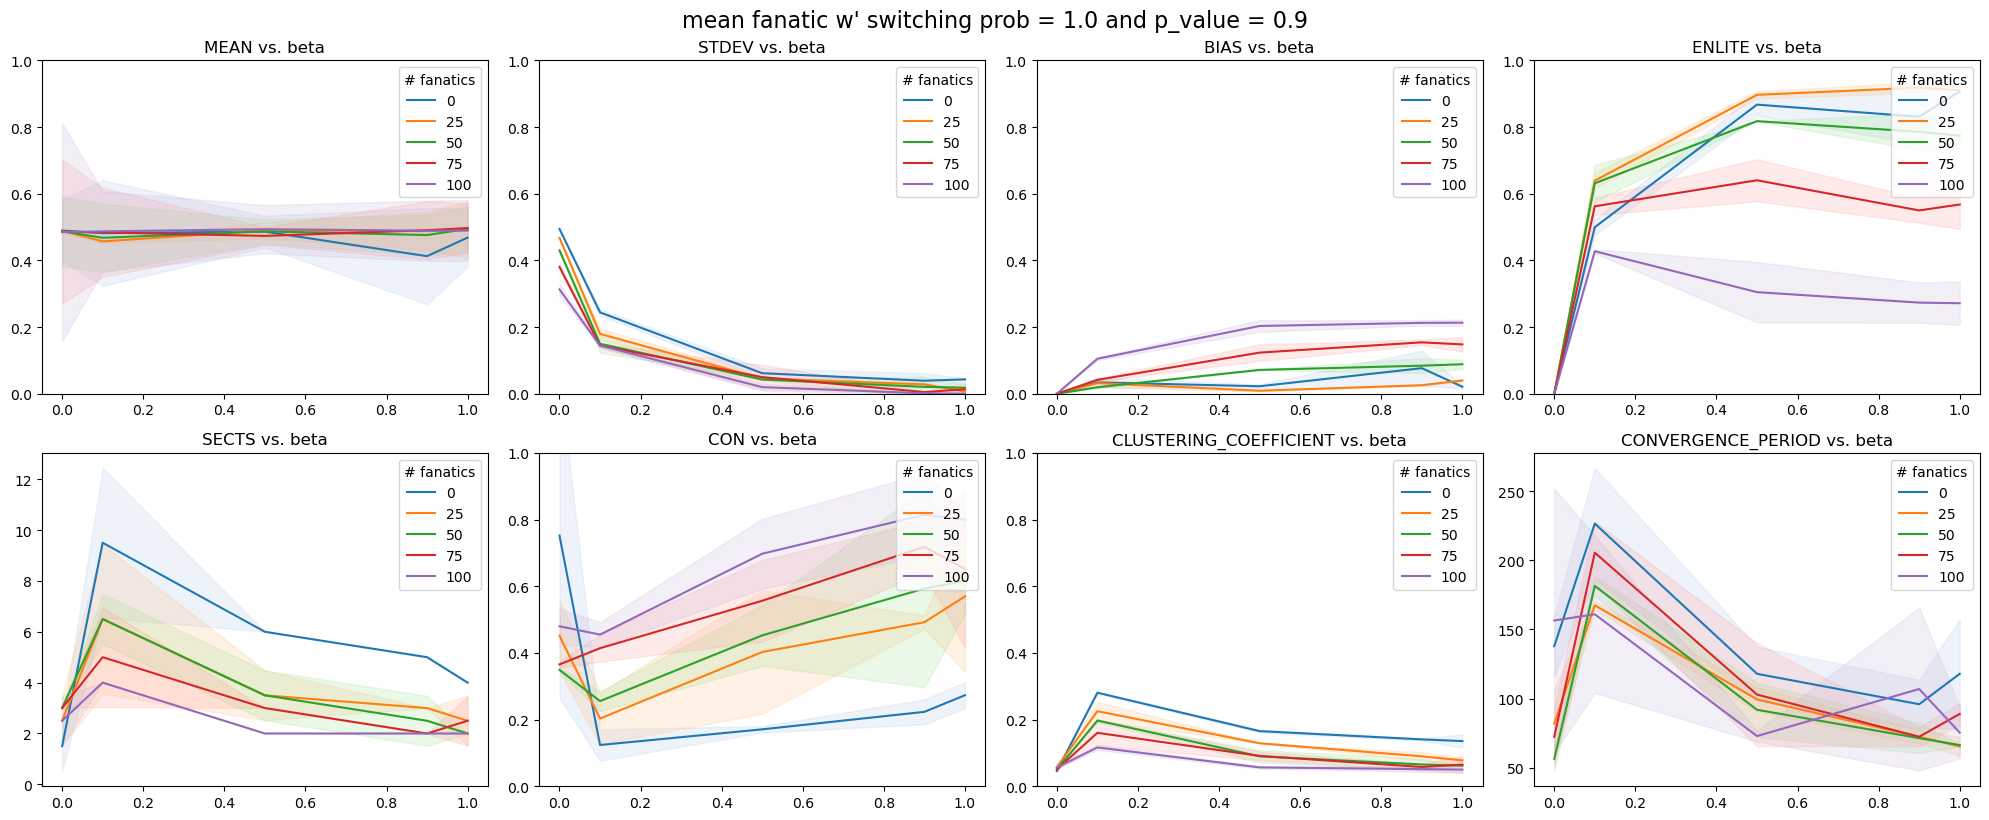

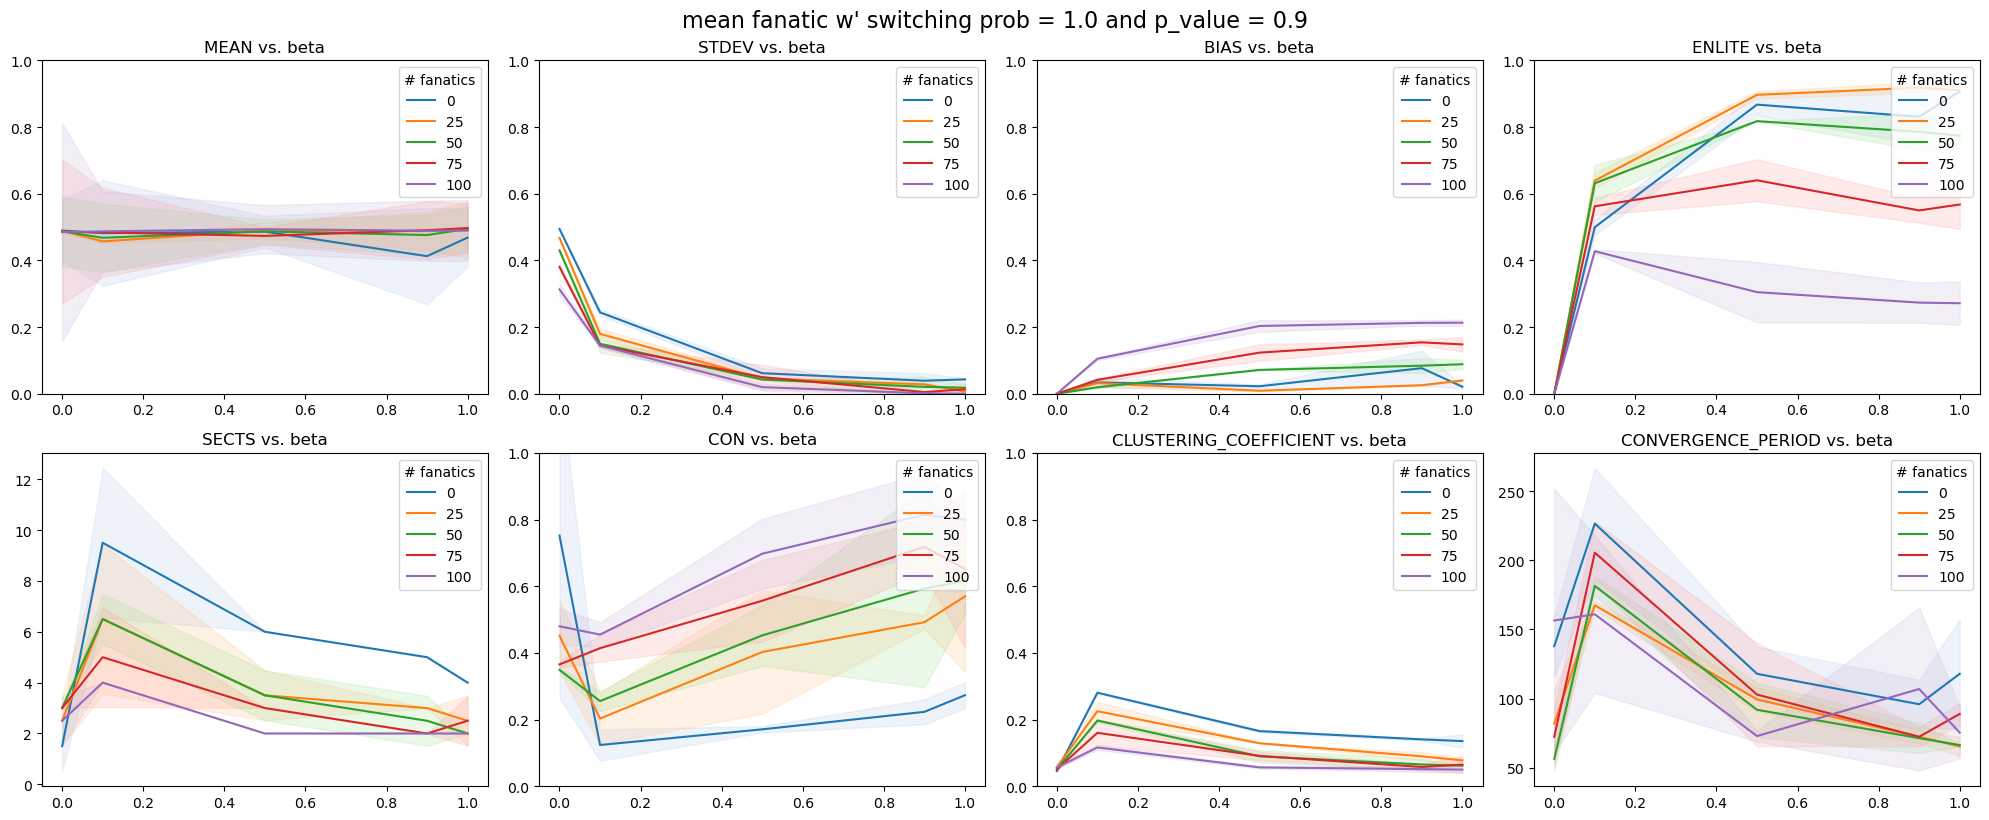

In [18]:
metrics= ['MEAN', 'STDEV', 'BIAS', 'ENLITE', 'SECTS', 'CON', 'CLUSTERING_COEFFICIENT', 'CONVERGENCE_PERIOD']

line_plot_with_confidence_interval(fanatics_max_low, metrics, DATE, TIME, export=True)
line_plot_with_confidence_interval(fanatics_max_high, metrics, DATE, TIME, export=True)
line_plot_with_confidence_interval(fanatics_min_max_low, metrics, DATE, TIME, export=True)
line_plot_with_confidence_interval(fanatics_min_max_high, metrics, DATE, TIME, export=True)
line_plot_with_confidence_interval(fanatics_mean_low, metrics, DATE, TIME, export=True)
line_plot_with_confidence_interval(fanatics_mean_high, metrics, DATE, TIME, export=True)

## Animation

### Network

In [11]:
# Visualize graphs
for s in [fanatics_max_low, fanatics_max_high, fanatics_mean_low, fanatics_mean_high, fanatics_min_max_low, fanatics_min_max_high]:
  for b in [0.1, 0.5, 1.0]:
    for f in [0, 25, 50, 75, 100]:
      network = s[(s['beta'] == b) & (s['num_fanatics'] == f)]['network_array'].reset_index(drop=True)[0]
      belief = s[(s['beta'] == b) & (s['num_fanatics'] == f)]['belief_array'].reset_index(drop=True)[0]
      scheme = s["fanatics_scheme"].sample().str.cat(sep='')
      switching_prob = s["switching_prob"].sample().values[0]
      visualize_graph(network, belief, -1, f, scheme, switching_prob, b, DATE, TIME, export=True)

In [4]:
# Animate graphs
animate_network(fanatics_max_high, 1.0, 50, DATE, TIME)